In [ ]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Example 1: same topic (sports)
same_topic = [
    "I love playing football on weekends.",
    "The football match was exciting yesterday.",
    "Soccer is my favorite sport.",
    "I practice football every day."
]

# Example 2: different topics
different_topics = [
    "I love playing football on weekends.",
    "The stock market crashed today.",
    "I cooked a delicious dinner last night.",
    "The new movie was fantastic."
]

# Example 3: large population (for global entropy)
many_topics = same_topic + different_topics

same_topic_twice = same_topic + same_topic


C:\Users\user\Desktop\github\circadian_social_network\transformers\src\transformers\tokenization_utils_base.py:1614: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# Embed sentences
X_same = model.encode(same_topic, normalize_embeddings=True)
X_diff = model.encode(different_topics, normalize_embeddings=True)
X_many = model.encode(many_topics, normalize_embeddings=True)
X_same_2 = model.encode(same_topic_twice, normalize_embeddings=True)

In [ ]:
def individual_entropy(X, k=2):
    import faiss
    X = X.astype("float32")
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    D, _ = index.search(X, k + 1)
    r_k = D[:, -1]
    return np.log(r_k + 1e-10)

# Individual entropy
ind_same = individual_entropy(X_same, k=2)
ind_diff = individual_entropy(X_diff, k=2)
ind_same = np.array(ind_same)
ind_diff = np.array(ind_diff)


print("Individual entropy (same topic):", ind_same)
print("Individual entropy (different topics):", ind_diff)

Individual entropy (same topic): [-0.04311999  0.189177    0.17514716  0.17514716]
Individual entropy (different topics): [0.50848943 0.6460058  0.42560223 0.50848943]


In [ ]:
def global_entropy(X, eps=1e-6):
    X = X.astype("float64")
    d = X.shape[1]
    cov = np.cov(X, rowvar=False) + eps * np.eye(d)
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        return np.nan
    return 0.5 * (d * np.log(2 * np.pi * np.e) + logdet)

glob_same = global_entropy(X_same)
glob_diff = global_entropy(X_diff)
glob_many = global_entropy(X_many)

print("Global entropy (same topic):", glob_same)
print("Global entropy (different topics):", glob_diff)
print("Global entropy (mixed population):", glob_many)

Global entropy (same topic): -4197.272191137539
Global entropy (different topics): -4196.5802497144205
Global entropy (mixed population): -4180.554984723434
Global entropy (same population x 2): -4197.50341533327


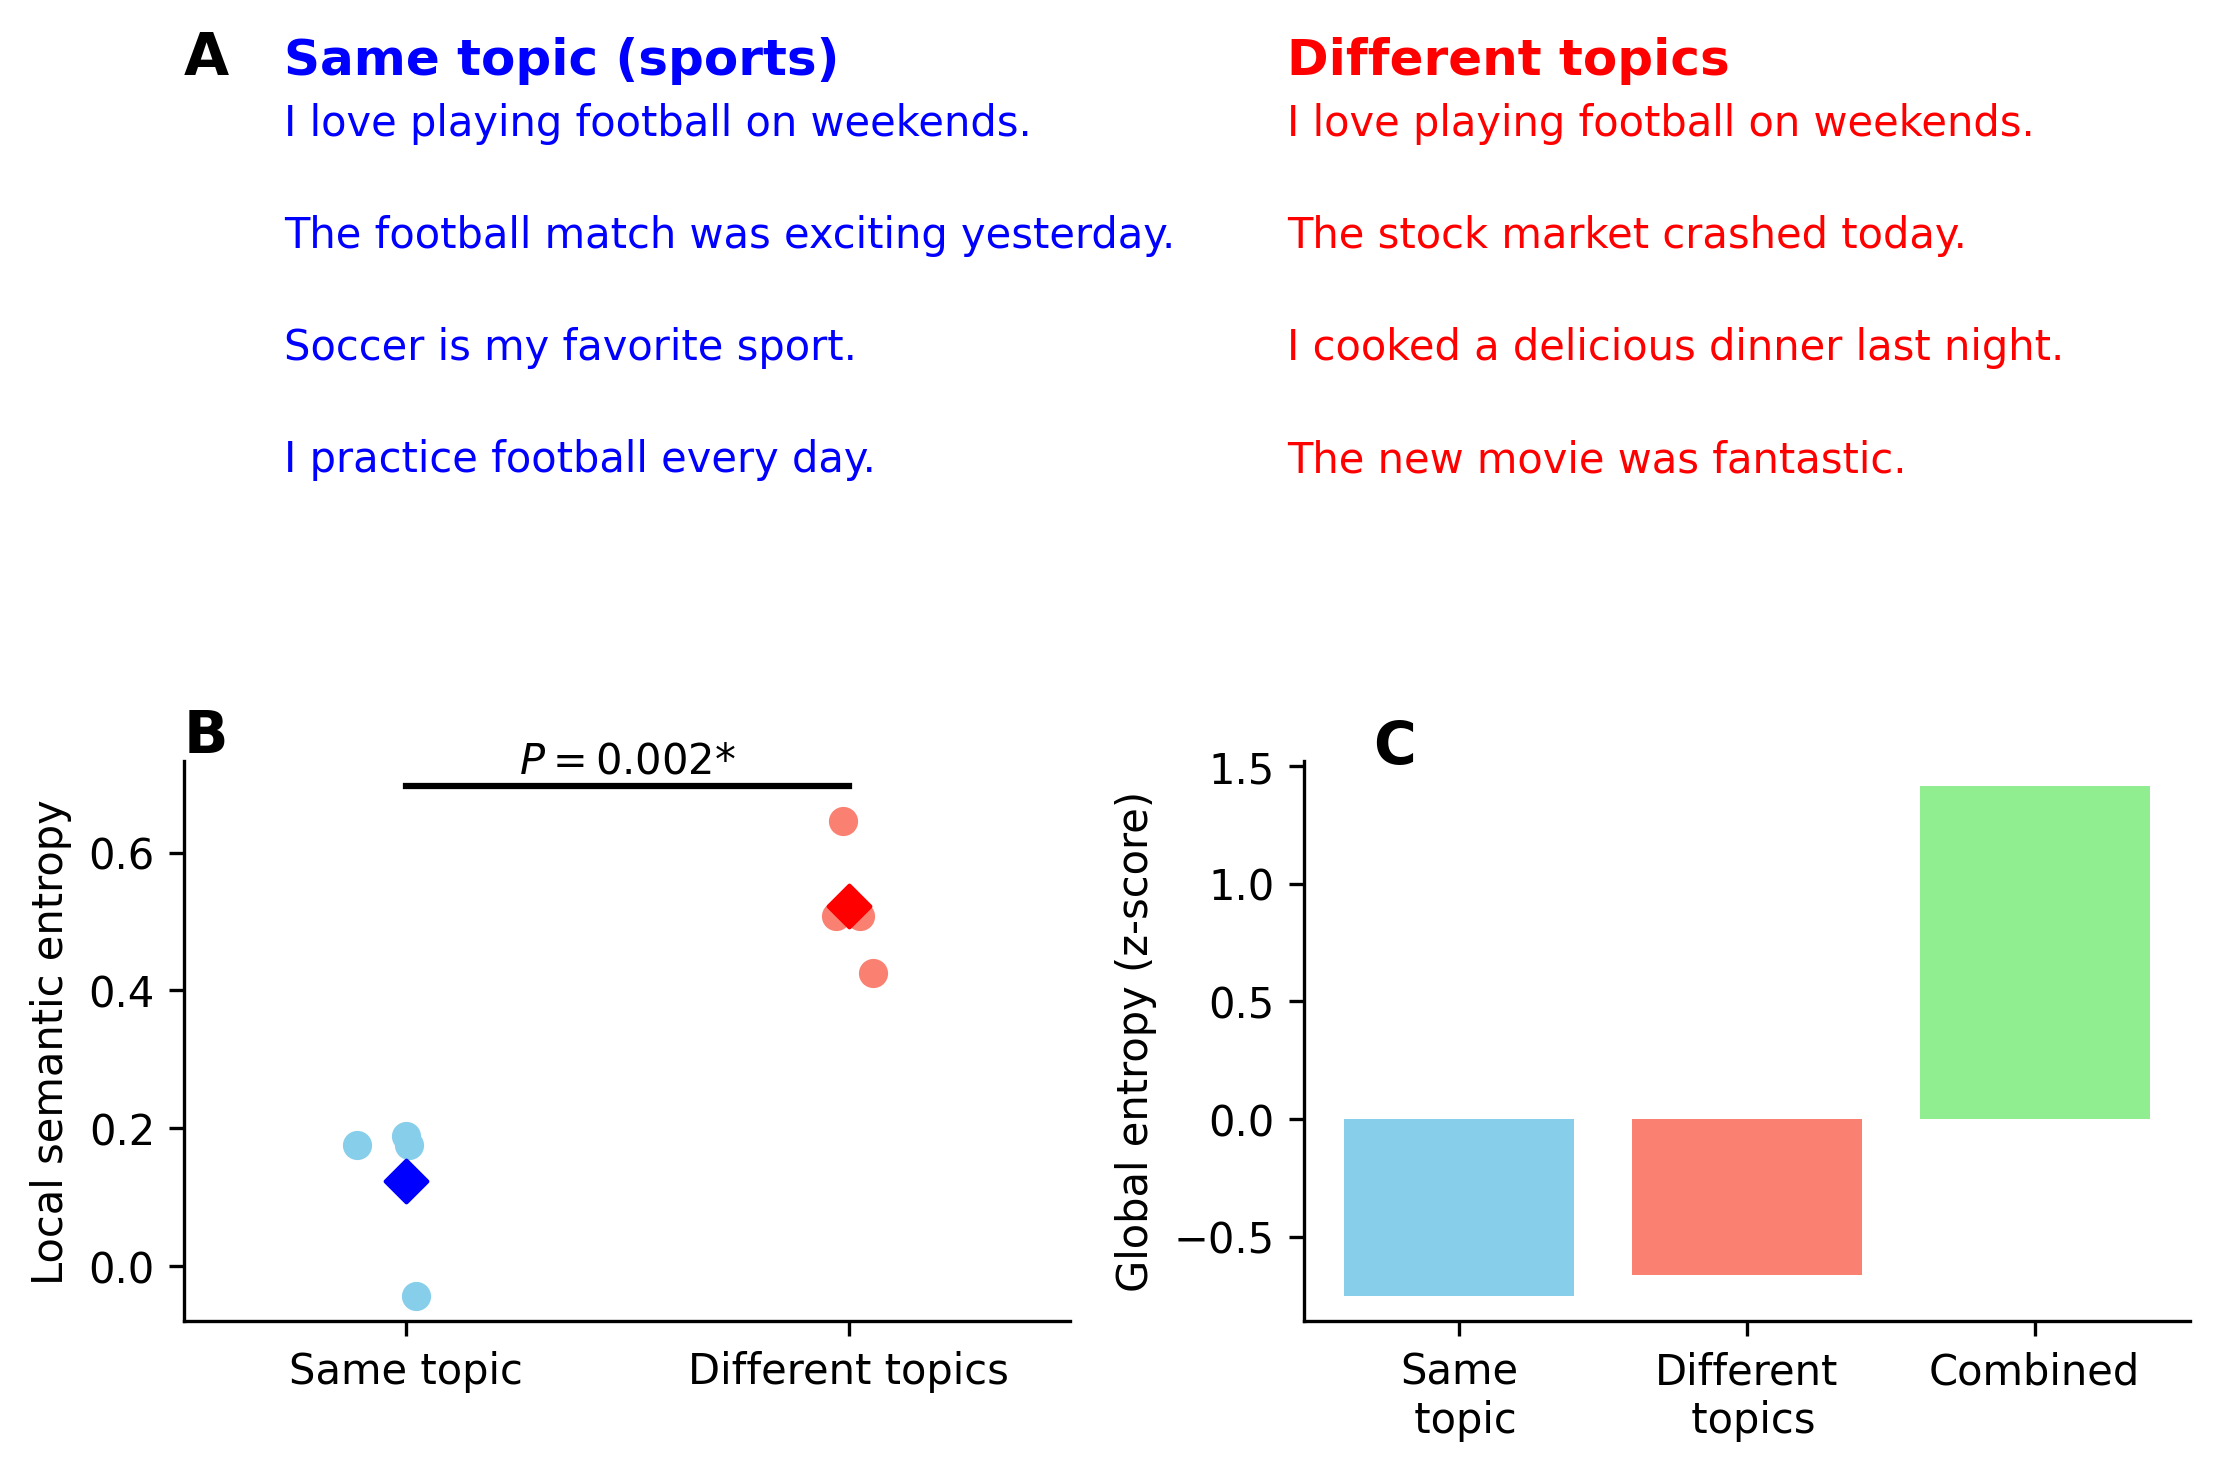

In [ ]:
# Simulate global entropy
glob_values = np.array([glob_same, glob_diff, glob_many])
glob_z = (glob_values - glob_values.mean()) / glob_values.std()

# ----------------------------
# Create figure with GridSpec
# ----------------------------
fig = plt.figure(figsize=(7.5,5), dpi=300)
gs = fig.add_gridspec(2, 2, height_ratios=[1,1])  # 2 rows, 2 columns

# --- Panel A: example sentences ---
axA = fig.add_subplot(gs[0,:])  # span top row
axA.axis("off")

for i, (s, d) in enumerate(zip(same_topic, different_topics)):
    axA.text(0.05, 1 - 0.2*i, s, fontsize=10, ha='left', va='top', color='blue')
    axA.text(0.55, 1 - 0.2*i, d, fontsize=10, ha='left', va='top', color='red')

axA.text(0.0, 1.05, "A", fontsize=14, fontweight='bold')  # panel label
axA.text(0.05, 1.05, "Same topic (sports)", fontsize=12, fontweight='bold', color='blue')
axA.text(0.55, 1.05, "Different topics", fontsize=12, fontweight='bold', color='red')

# --- Panel B: local semantic entropy ---
axB = fig.add_subplot(gs[1,0])

# t-test
t_stat, p_val = ttest_ind(ind_same, ind_diff, equal_var=False)

# scatter positions
x_same = np.random.normal(0, 0.05, size=len(ind_same))
x_diff = np.random.normal(1, 0.05, size=len(ind_diff))

axB.scatter(x_same, ind_same, color='skyblue', label='Same topic')
axB.scatter(x_diff, ind_diff, color='salmon', label='Different topics')

# mean markers
axB.scatter([0], [ind_same.mean()], color='blue', marker='D', s=50)
axB.scatter([1], [ind_diff.mean()], color='red', marker='D', s=50)

axB.set_xticks([0,1])
axB.set_xticklabels(["Same topic", "Different topics"])
axB.set_ylabel("Local semantic entropy")
y_max = max(ind_same.max(), ind_diff.max())
axB.plot([0,1], [y_max+0.05]*2, color='k')
axB.text(0.5, y_max+0.07, f"$P = {p_val:.3f}$*", ha='center')

axB.text(-0.5, y_max+0.1, "B", fontsize=14, fontweight='bold')  # panel label
axB.set_xlim(-0.5, 1.5)
sns.despine(ax=axB)

# --- Panel C: global entropy ---
axC = fig.add_subplot(gs[1,1])

axC.bar(
    ["Same\n topic", "Different\n topics", 
     "Combined\n"],
    glob_z,
    color=["skyblue", "salmon", "lightgreen"]
)
axC.set_ylabel("Global entropy (z-score)")
axC.text(-0.3, max(glob_z)+0.1, "C", fontsize=14, fontweight='bold')

sns.despine(ax=axC)

plt.tight_layout()
plt.savefig("FigureS1.png")

In [ ]:
import pandas as pd
import geopandas as gpd
import geodatasets as gds
# Load naturalearth low-res countries
# ----------------------------
# Load world map from Natural Earth online
# ----------------------------
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

data = pd.read_csv("individual_entropy_filtered.csv")

C:\Users\user\anaconda3\envs\ssq_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


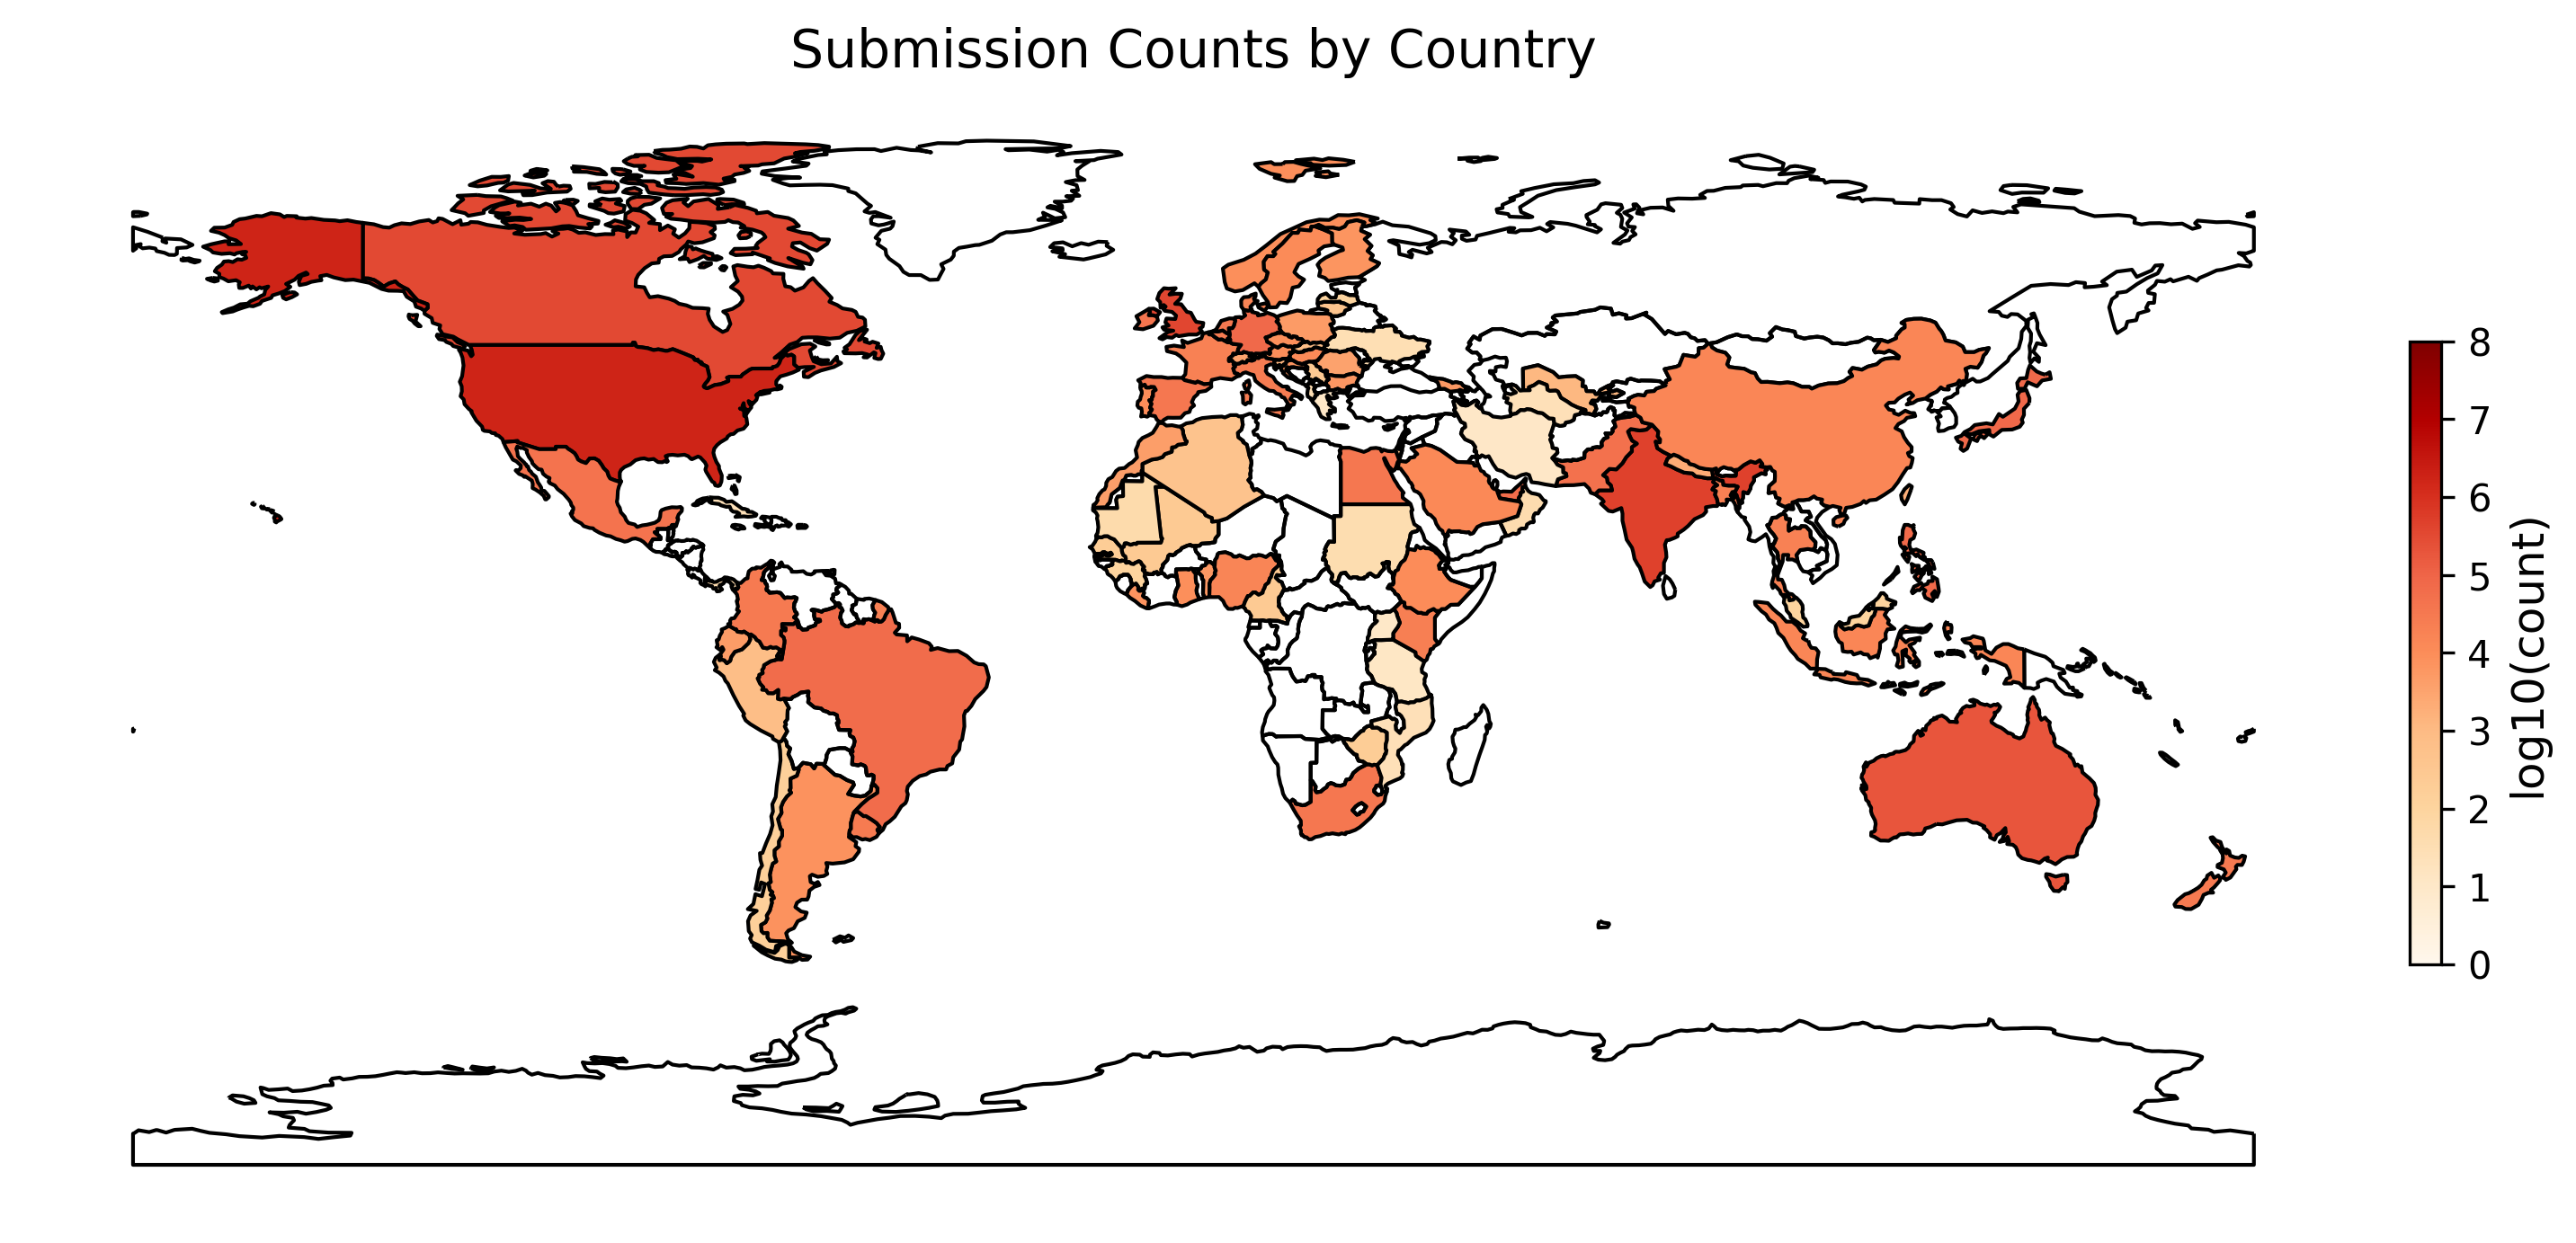

In [30]:
# Aggregate counts by country
country_counts = data.groupby("loc_country").size().reset_index(name="submission_count")
country_counts.loc[country_counts["loc_country"]=="United States","loc_country"]="United States of America"
# Merge counts with world geometries
world_counts = world.merge(country_counts, how="left", left_on="NAME", right_on="loc_country")
world_counts["submission_count"] = world_counts["submission_count"].fillna(0)
world_counts["submission_count"] = np.log10(world_counts["submission_count"]) 

fig, ax = plt.subplots(figsize=(12,6), dpi=300)
# Plot countries with bold borders
world_counts.plot(
    column="submission_count",
    cmap="OrRd",
    linewidth=1,
    edgecolor="black",
    ax=ax,
    legend=False,  # we will make a custom colorbar
    vmin=0,
    vmax=8
)

# Create smaller colorbar
import matplotlib as mpl
sm = mpl.cm.ScalarMappable(cmap="OrRd", norm=plt.Normalize(vmin=0, vmax=8))
sm._A = []  # dummy array
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.02, shrink=0.5)  # fraction controls size
cbar.set_label("log10(count)", fontsize=12)

ax.set_title("Submission Counts by Country", fontsize=14)
ax.axis("off")

plt.show()

In [31]:
import pygmt

# # Approximate lat/lon of country centroids
# countries = {
#     "United States": {"lat": 39.8, "lon": -98.6},
#     "United Kingdom": {"lat": 55.4, "lon": -3.4},
#     "Canada": {"lat": 61.0, "lon": -107.0},
#     "India": {"lat": 22.0, "lon": 79.0}
# }

# fig = pygmt.Figure()

# # Draw global coastlines
# fig.coast(
#     region="d",          # global region
#     projection="W12c",   # world map in Winkel Tripel
#     frame="afg",
#     land="ivory",
#     water="grey"
# )

# # Plot countries as points
# for country, coord in countries.items():
#     fig.plot(x=coord["lon"], y=coord["lat"], style="c0.5c",  pen="black")

# # Optionally, label countries
# for country, coord in countries.items():
#     fig.text(x=coord["lon"]+3, y=coord["lat"], text=country, font="10p,Helvetica-Bold,black")

# fig.show()

coast [WARNING]: Length <unit> k not supported - revert to default unit [point]
coast [WARNING]: 0.5p/blac not a valid number and may not be decoded properly.


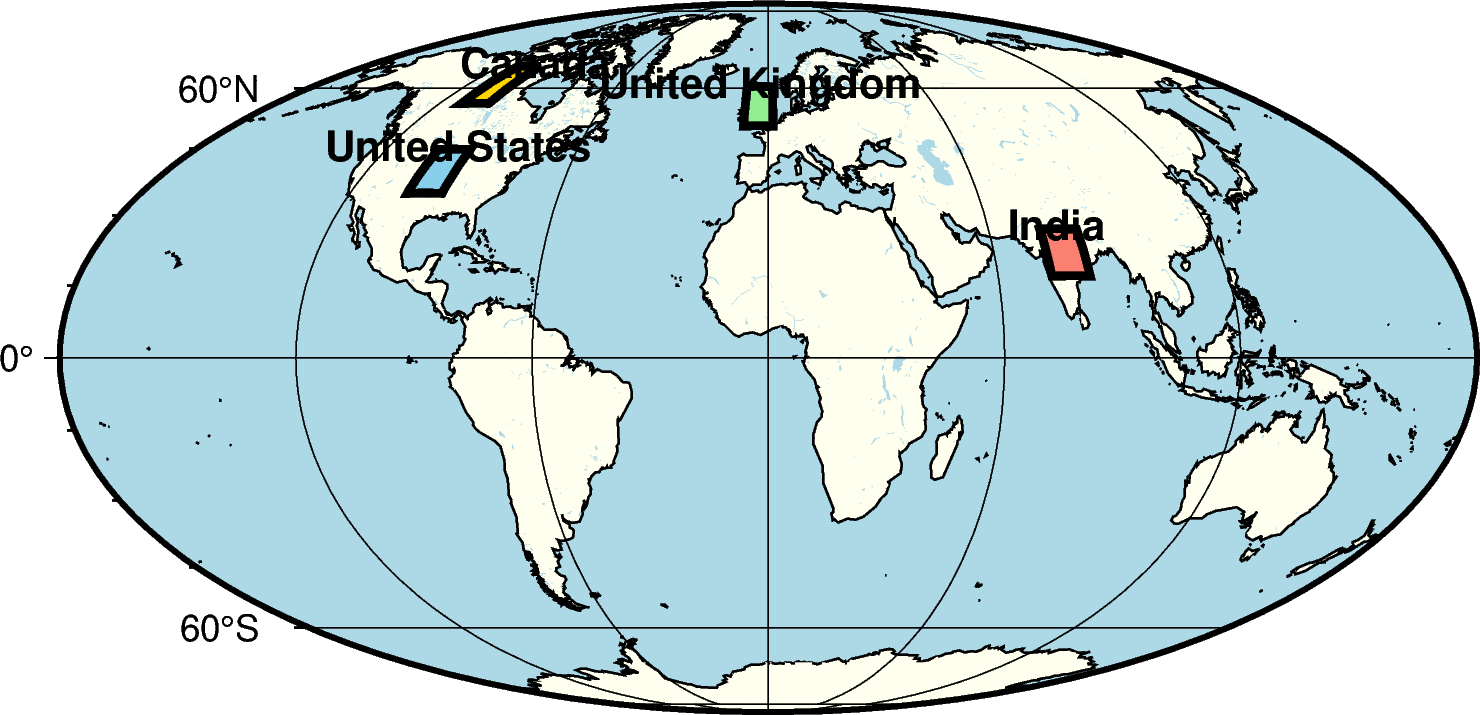

In [32]:
# Country centroids and approximate bounding boxes
countries = {
    "United States": {"lat": 39.8, "lon": -98.6, "fill":"skyblue"},
    "United Kingdom": {"lat": 55.4, "lon": -3.4, "fill":"lightgreen"},
    "Canada": {"lat": 61.0, "lon": -107.0, "fill":"gold"},
    "India": {"lat": 22.0, "lon": 79.0, "fill":"salmon"}
}

fig = pygmt.Figure()

# Draw global coastlines
fig.coast(
    region="d",          
    projection="W12c",   
    frame="afg",
    land="ivory",
    water="lightblue",
    shorelines="1/0.5p/black"
)

# Overlay country shading using rectangles (illustrative)
for country, coord in countries.items():
    fig.plot(
        x=[coord["lon"]-5, coord["lon"]+5, coord["lon"]+5, coord["lon"]-5, coord["lon"]-5],
        y=[coord["lat"]-5, coord["lat"]-5, coord["lat"]+5, coord["lat"]+5, coord["lat"]-5],

        fill=coord["fill"],  # <--- corrected
        pen="2p,black"
    )

    # Label
    fig.text(x=coord["lon"], y=coord["lat"]+6, text=country, font="10p,Helvetica-Bold,black", justify="CM")

fig.show()

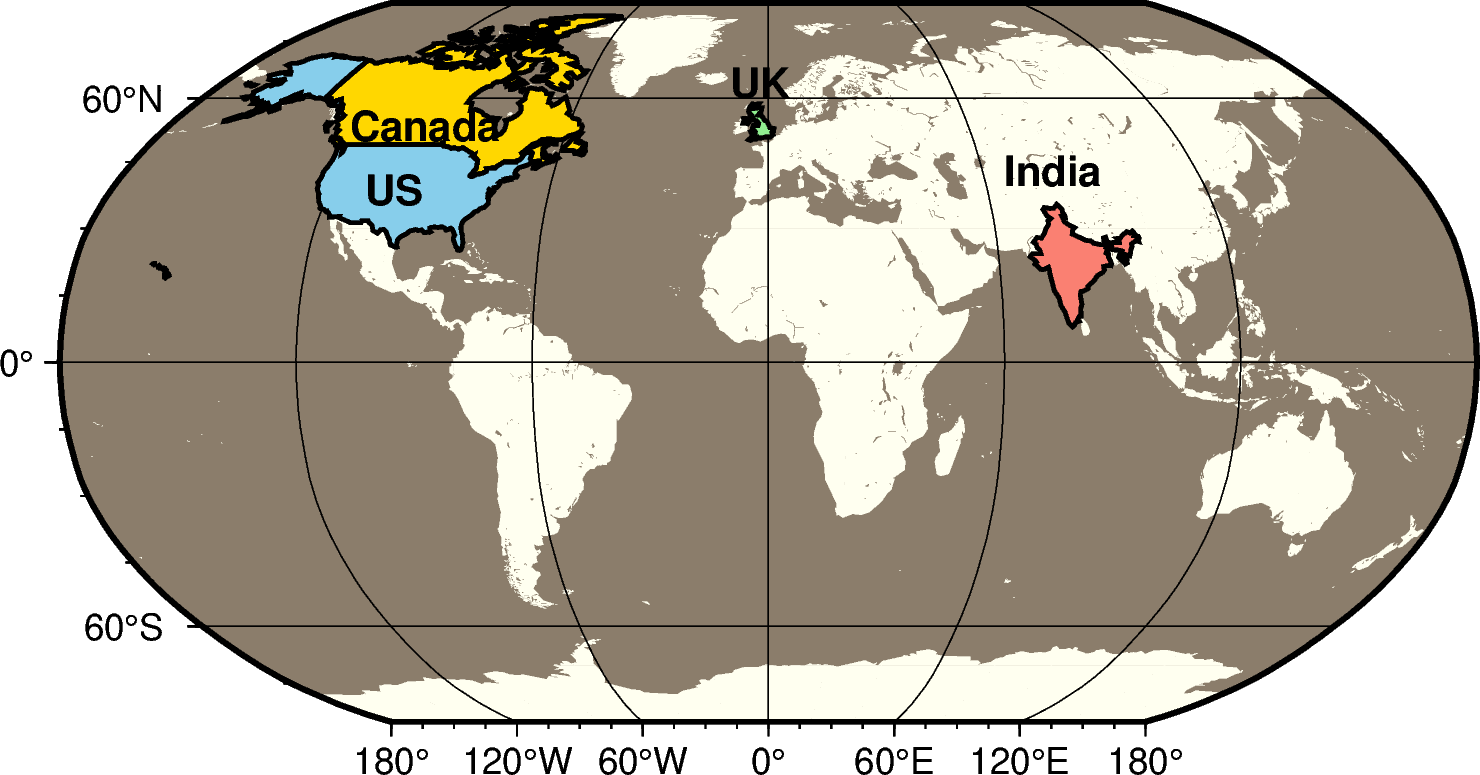

In [33]:
# Filter the four countries
selected_countries = ["United States of America", "United Kingdom", "Canada", "India"]
world_selected = world[world["NAME"].isin(selected_countries)]

# Short names for labels
short_names = {
    "United States of America": "US",
    "United Kingdom": "UK",
    "Canada": "Canada",
    "India": "India"
}

# ----------------------------
# PyGMT Figure
# ----------------------------
fig = pygmt.Figure()

# Set map region to global, Winkel Tripel projection
# fig.basemap(region="d", projection="N12c", frame="afg")
fig.coast(region="d", projection="N12c", frame="afg", land="ivory", water="bisque4")

# Plot each country polygon with border and fill
for _, row in world_selected.iterrows():
    geom = row.geometry
    geoms = geom.geoms if hasattr(geom, "geoms") else [geom]
    for g in geoms:
        lon, lat = g.exterior.xy
        fig.plot(
            x=lon,
            y=lat,
            pen="1p,black",
            fill=(
                "skyblue" if row["NAME"]=="United States of America" else
                "lightgreen" if row["NAME"]=="United Kingdom" else
                "gold" if row["NAME"]=="Canada" else
                "salmon"
            )
        )

# Add labels slightly offset from centroid
offsets = {
    "United States of America": (10, -7),   # move 10 degrees north
    "United Kingdom": (0, 10),             # move 5 degrees south
    "Canada": (-5, -8),                     # move 10 degrees north
    "India": (0, 20)                        # move 5 degrees south
}

for _, row in world_selected.iterrows():
    centroid = row.geometry.centroid
    dx, dy = offsets[row["NAME"]]
    fig.text(
        x=centroid.x + dx,
        y=centroid.y + dy,
        text=short_names[row["NAME"]],
        font="10p,Helvetica-Bold,black",
        justify="CM"
    )

fig.show()

Posts per subreddit stats:
Mean: 10.0
Median: 0.0
Max: 38575
Min: 0


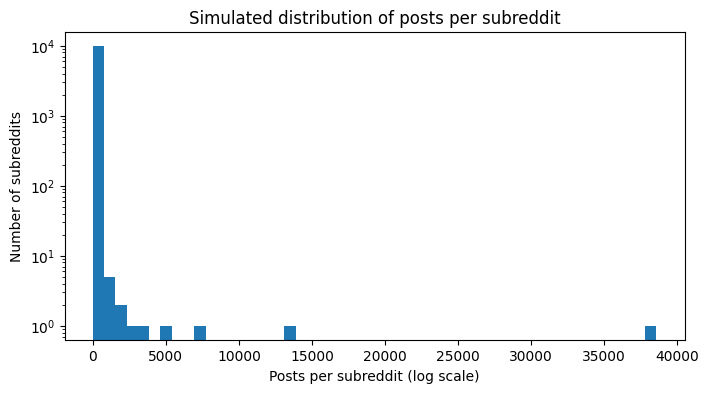

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_posts = 100_000
num_subreddits = 10_000
zipf_param = 1.5  # controls skewness; higher = more skewed

# Step 1: generate power-law weights
ranks = np.arange(1, num_subreddits + 1)
weights = 1 / ranks**zipf_param
weights /= weights.sum()  # normalize

# Step 2: allocate posts per subreddit
posts_per_subreddit = np.floor(weights * total_posts).astype(int)

# Step 3: adjust to match total_posts exactly
diff = total_posts - posts_per_subreddit.sum()
if diff > 0:
    posts_per_subreddit[:diff] += 1
elif diff < 0:
    posts_per_subreddit[: -diff] -= 1

# Step 4: statistics
print("Posts per subreddit stats:")
print("Mean:", posts_per_subreddit.mean())
print("Median:", np.median(posts_per_subreddit))
print("Max:", posts_per_subreddit.max())
print("Min:", posts_per_subreddit.min())

# Step 5: visualize
plt.figure(figsize=(8,4))
plt.hist(posts_per_subreddit, bins=50, log=True)
plt.xlabel("Posts per subreddit (log scale)")
plt.ylabel("Number of subreddits")
plt.title("Simulated distribution of posts per subreddit")
plt.show()


Posts per subreddit stats:
Mean: 10.0
Median: 2.0
Max: 18823
Min: 1


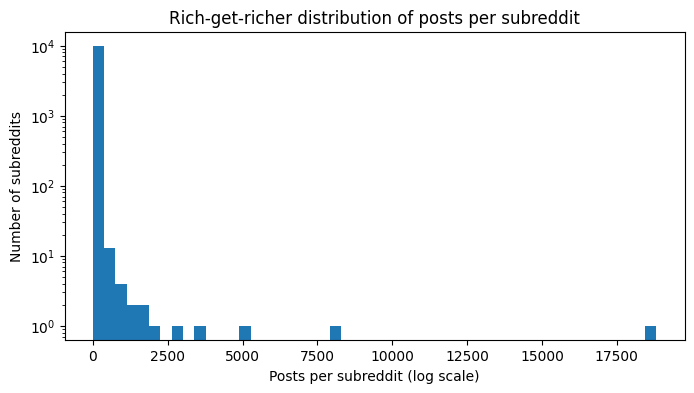

Total posts: 100000
FAISS index built.
Computing kNN distances...


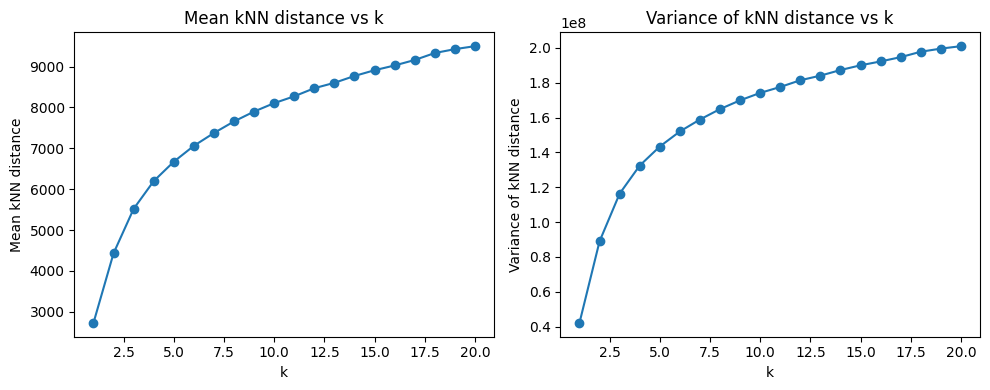

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
from tqdm import tqdm

# ----------------------------
# Simulation parameters
# ----------------------------
total_posts = 100_000
num_subreddits = 10_000
d = 768                # embedding dimension
max_k = 20           # kNN neighborhood size

# ----------------------------
# Step 1: Fast rich-get-richer allocation
# ----------------------------
# Approximate preferential attachment using Zipf-like weights
ranks = np.arange(1, num_subreddits + 1)
weights = 1 / ranks**1.2
weights /= weights.sum()

# Allocate posts per subreddit
posts_per_subreddit = np.ones(num_subreddits, dtype=int)  # start with 1 post
remaining_posts = total_posts - num_subreddits
additional_posts = np.random.multinomial(remaining_posts, weights)
posts_per_subreddit += additional_posts

# ----------------------------
# Step 2: Statistics and visualization
# ----------------------------
print("Posts per subreddit stats:")
print("Mean:", posts_per_subreddit.mean())
print("Median:", np.median(posts_per_subreddit))
print("Max:", posts_per_subreddit.max())
print("Min:", posts_per_subreddit.min())

plt.figure(figsize=(8,4))
plt.hist(posts_per_subreddit, bins=50, log=True)
plt.xlabel("Posts per subreddit (log scale)")
plt.ylabel("Number of subreddits")
plt.title("Rich-get-richer distribution of posts per subreddit")
plt.show()

# ----------------------------
# Step 3: Generate embeddings
# ----------------------------
n_points = posts_per_subreddit.sum()
print("Total posts:", n_points)

# Random embeddings, clustered by subreddit
reddit_embeddings = np.empty((n_points, d), dtype=np.float32)
idx = 0
for count in posts_per_subreddit:
    cluster_center = np.random.randn(d).astype(np.float32) * 5
    reddit_embeddings[idx:idx+count] = np.random.randn(count, d).astype(np.float32) + cluster_center
    idx += count

# ----------------------------
# Step 4: Fit FAISS kNN index
# ----------------------------
index = faiss.IndexFlatL2(d)  # CPU brute-force
index.add(reddit_embeddings)
print("FAISS index built.")

# ----------------------------
# Step 5: Compute kNN distances
# ----------------------------
print("Computing kNN distances...")
D, _ = index.search(reddit_embeddings, max_k + 1)  # +1 because self-distance included
r_k = D[:, -1]  # distance to k-th neighbor

# Mean and variance of distances for each k
mean_distances = np.zeros(max_k)
var_distances = np.zeros(max_k)
for k in range(1, max_k + 1):
    kd = D[:, k]
    mean_distances[k-1] = kd.mean()
    var_distances[k-1] = kd.var()

# ----------------------------
# Step 6: Plot results
# ----------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_k+1), mean_distances, marker='o')
plt.xlabel("k")
plt.ylabel("Mean kNN distance")
plt.title("Mean kNN distance vs k")

plt.subplot(1, 2, 2)
plt.plot(range(1, max_k+1), var_distances, marker='o')
plt.xlabel("k")
plt.ylabel("Variance of kNN distance")
plt.title("Variance of kNN distance vs k")

plt.tight_layout()
plt.show()


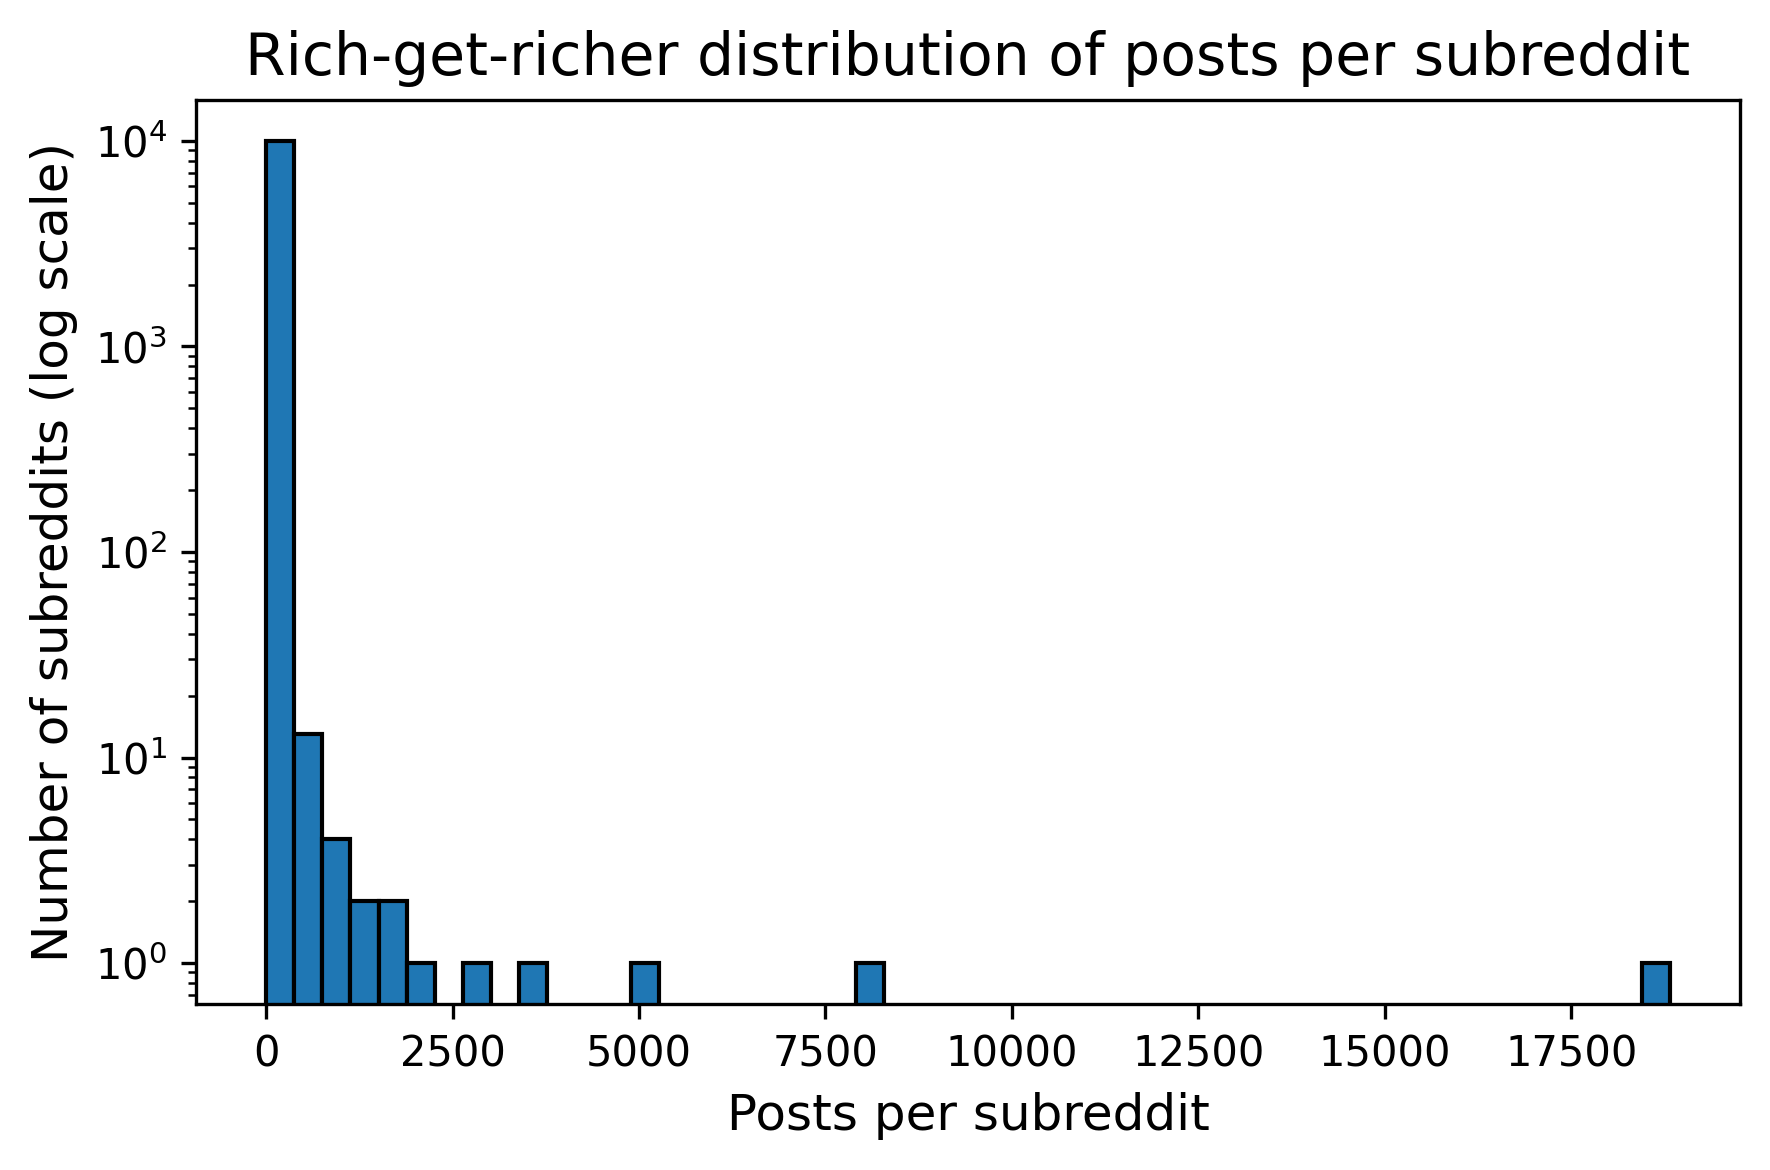

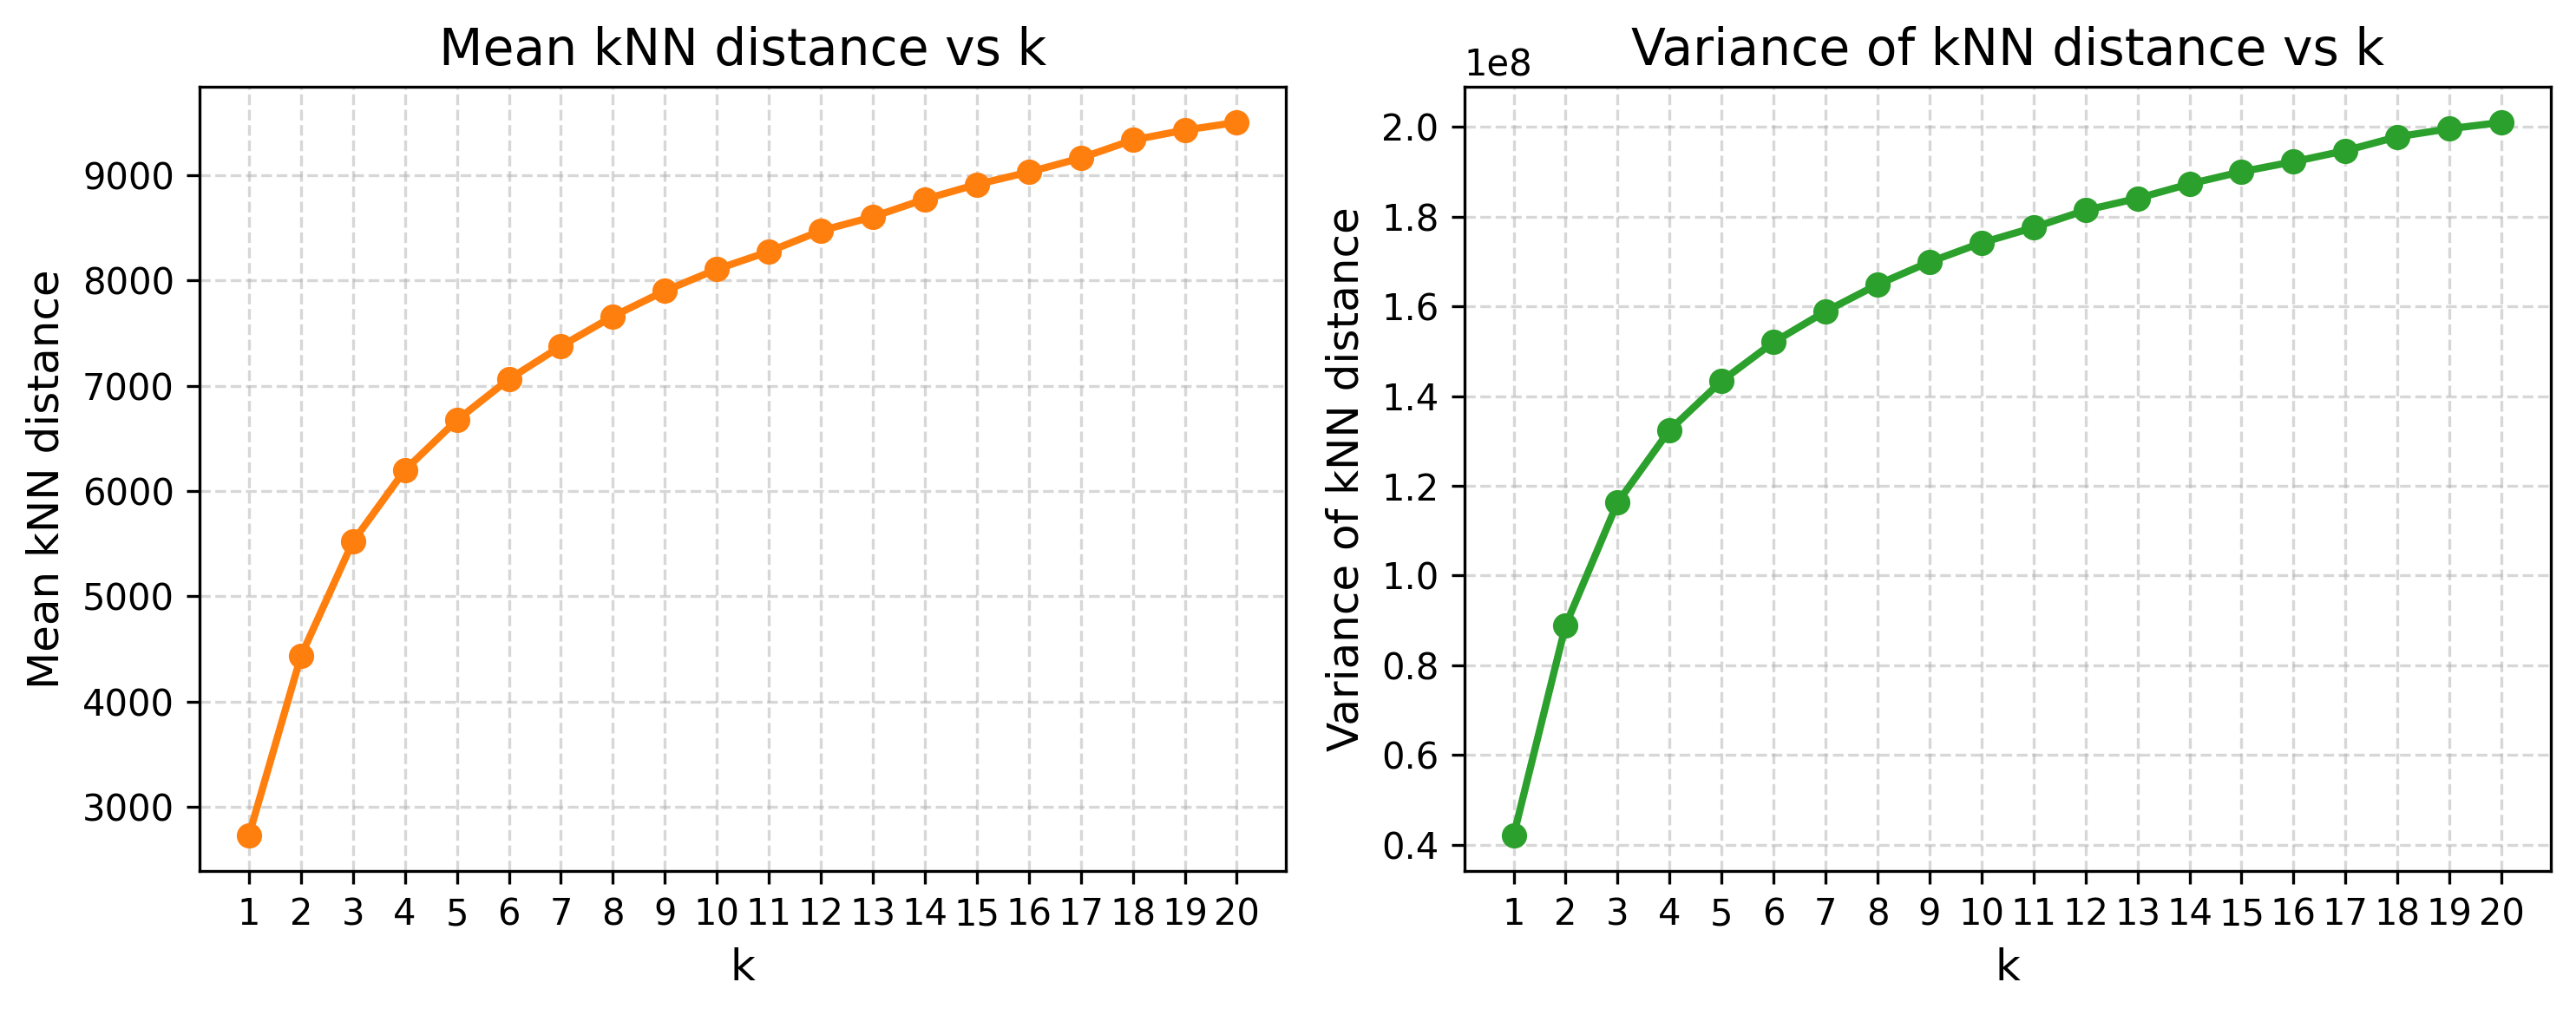

Variance explained at k=10: 39.59%


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Publication-ready: Posts per subreddit
# ----------------------------
plt.figure(figsize=(6,4), dpi=300)
plt.hist(posts_per_subreddit, bins=50, log=True, color="#1f77b4", edgecolor="black")
plt.xlabel("Posts per subreddit", fontsize=12)
plt.ylabel("Number of subreddits (log scale)", fontsize=12)
plt.title("Rich-get-richer distribution of posts per subreddit", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# ----------------------------
# Publication-ready: kNN distances
# ----------------------------
plt.figure(figsize=(10,4), dpi=300)

# Mean distance plot
plt.subplot(1,2,1)
plt.plot(range(1, max_k+1), mean_distances, marker='o', color="#ff7f0e", linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("Mean kNN distance", fontsize=12)
plt.title("Mean kNN distance vs k", fontsize=14)
plt.xticks(range(1, max_k+1))
plt.grid(True, linestyle='--', alpha=0.5)

# Variance plot
plt.subplot(1,2,2)
plt.plot(range(1, max_k+1), var_distances, marker='o', color="#2ca02c", linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("Variance of kNN distance", fontsize=12)
plt.title("Variance of kNN distance vs k", fontsize=14)
plt.xticks(range(1, max_k+1))
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ----------------------------
# Variance explained at k=10
# ----------------------------
# Sum of squared distances for first k neighbors
k_chosen = 10
sum_sq_k = np.sum(D[:, 1:k_chosen+1]**2)

# Sum of squared distances for all max_k neighbors
sum_sq_total = np.sum(D[:, 1:max_k+1]**2)

variance_explained = sum_sq_k / sum_sq_total
print(f"Variance explained at k={k_chosen}: {variance_explained*100:.2f}%")


Posts per subreddit stats:
Mean: 1.0
Median: 1.0
Max: 64
Min: 0


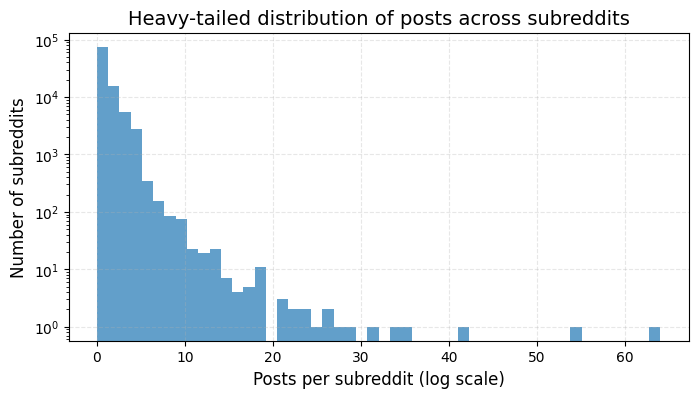

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Simulation parameters
# ----------------------------
total_posts = 100_000        # total submissions
num_subreddits = 100_000     # total subreddits (clusters)
zipf_param = 0.4          # controls skewness: higher = more skewed
d = 20                        # embedding dimension

# ----------------------------
# Step 1: Allocate posts to subreddits (heavy-tailed)
# ----------------------------
# Generate Zipf-like weights
ranks = np.arange(1, num_subreddits + 1)
weights = 1 / ranks**zipf_param
weights /= weights.sum()  # normalize

# Allocate posts via multinomial
posts_per_subreddit = np.random.multinomial(total_posts, weights)

# Add 1 to avoid empty subreddits if desired
# posts_per_subreddit += 1
# Adjust total_posts if needed
# total_posts = posts_per_subreddit.sum()

print("Posts per subreddit stats:")
print("Mean:", posts_per_subreddit.mean())
print("Median:", np.median(posts_per_subreddit))
print("Max:", posts_per_subreddit.max())
print("Min:", posts_per_subreddit.min())

# Visualize distribution
plt.figure(figsize=(8,4))
plt.hist(posts_per_subreddit, bins=50, log=True, color="#1f77b4", alpha=0.7)
plt.xlabel("Posts per subreddit (log scale)", fontsize=12)
plt.ylabel("Number of subreddits", fontsize=12)
plt.title("Heavy-tailed distribution of posts across subreddits", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# ---------------


C:\Users\user\AppData\Local\Temp\ipykernel_13436\4166204940.py:55: RuntimeWarning: invalid value encountered in divide
  coverage = np.minimum(posts_per_subreddit-1, k_chosen) / (posts_per_subreddit-1)


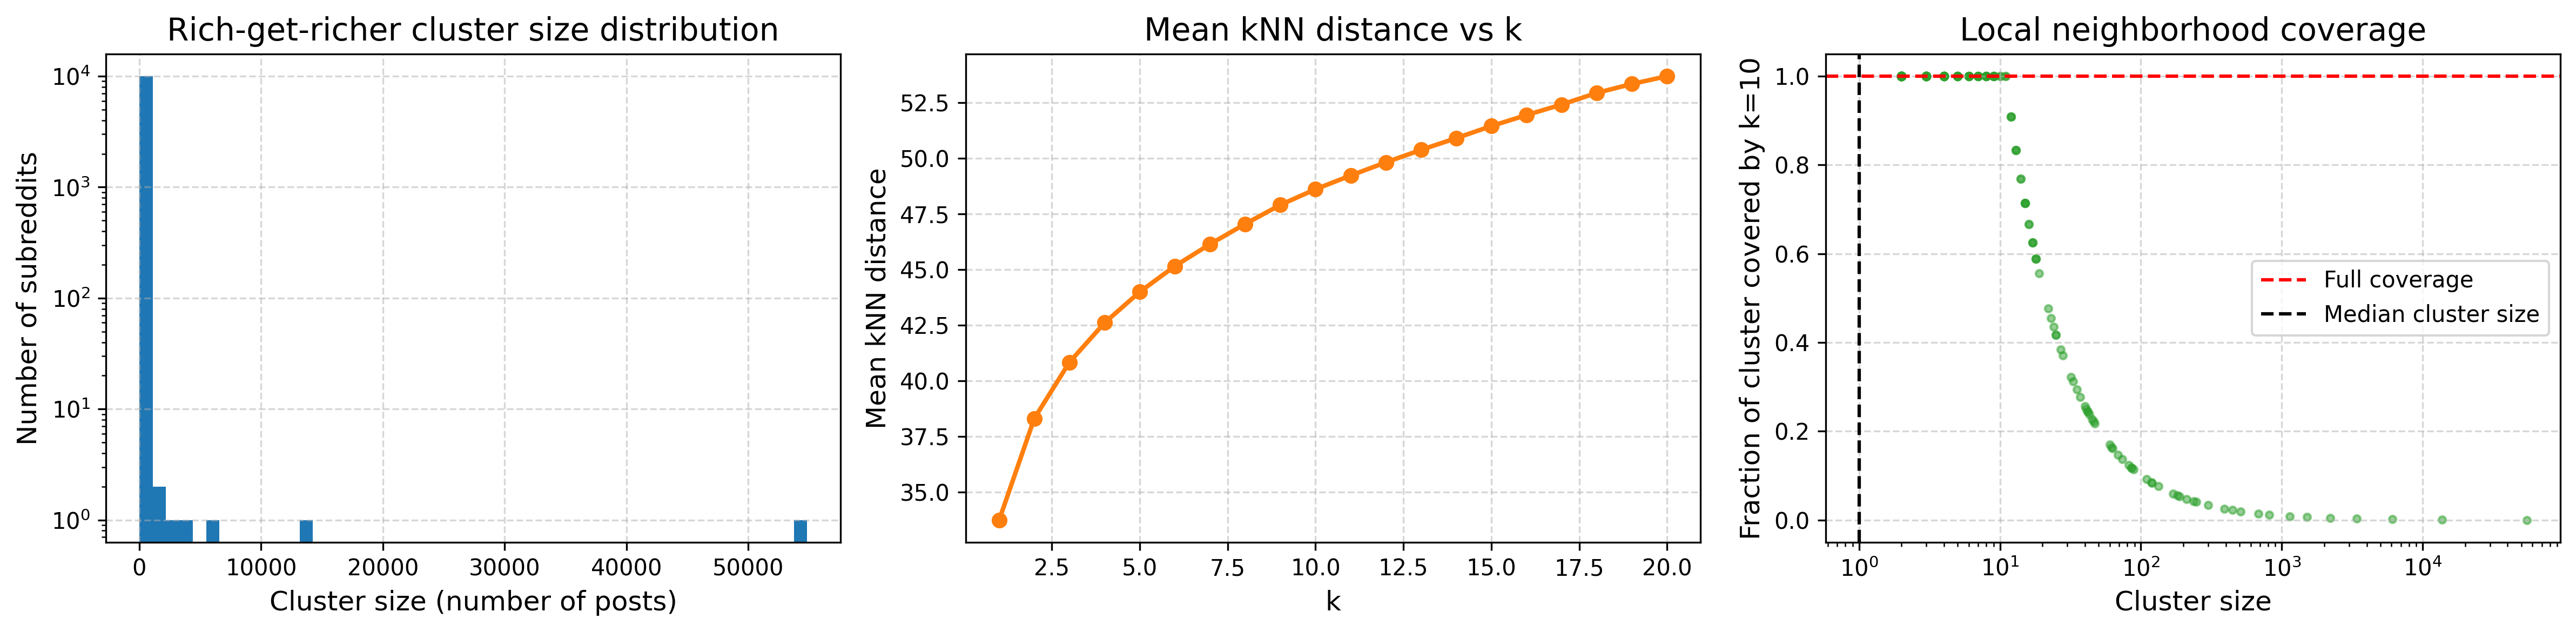

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
from tqdm import tqdm

# ----------------------------
# Simulation parameters
# ----------------------------
total_posts = 100_000
num_subreddits = 10_000
d = 20
max_k = 20  # for kNN distances

# ----------------------------
# Step 1: Rich-get-richer cluster sizes
# ----------------------------
# Zipf-like preferential attachment approximation
ranks = np.arange(1, num_subreddits + 1)
weights = 1 / ranks**2
weights /= weights.sum()

posts_per_subreddit = np.ones(num_subreddits, dtype=int)
remaining_posts = total_posts - num_subreddits
posts_per_subreddit += np.random.multinomial(remaining_posts, weights)

# ----------------------------
# Step 2: Generate embeddings (clustered)
# ----------------------------
n_points = posts_per_subreddit.sum()
reddit_embeddings = np.empty((n_points, d), dtype=np.float32)
idx = 0
for count in posts_per_subreddit:
    cluster_center = np.random.randn(d).astype(np.float32) * 5
    reddit_embeddings[idx:idx+count] = np.random.randn(count, d).astype(np.float32) + cluster_center
    idx += count

# ----------------------------
# Step 3: Fit FAISS kNN
# ----------------------------
index = faiss.IndexFlatL2(d)
index.add(reddit_embeddings)

D, _ = index.search(reddit_embeddings, max_k+1)  # distances including self

# ----------------------------
# Step 4: Compute kNN mean & variance
# ----------------------------
mean_distances = np.array([D[:, k].mean() for k in range(1, max_k+1)])
var_distances = np.array([D[:, k].var() for k in range(1, max_k+1)])

# ----------------------------
# Step 5: Compute fraction of cluster coverage at k
# ----------------------------
k_chosen = 10
coverage = np.minimum(posts_per_subreddit-1, k_chosen) / (posts_per_subreddit-1)

# ----------------------------
# Step 6: Plot multi-panel figure
# ----------------------------
plt.figure(figsize=(16,4), dpi=300)

# Panel A: Cluster size histogram
plt.subplot(1,3,1)
plt.hist(posts_per_subreddit, bins=50, log=True, color="#1f77b4")
plt.xlabel("Cluster size (number of posts)", fontsize=12)
plt.ylabel("Number of subreddits", fontsize=12)
plt.title("Rich-get-richer cluster size distribution", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Panel B: Mean kNN distance vs k
plt.subplot(1,3,2)
plt.plot(range(1,max_k+1), mean_distances, marker='o', color="#ff7f0e", linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("Mean kNN distance", fontsize=12)
plt.title("Mean kNN distance vs k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Panel C: Coverage fraction vs cluster size
plt.subplot(1,3,3)
plt.scatter(posts_per_subreddit, coverage, alpha=0.5, s=10, color="#2ca02c")
plt.axhline(1.0, color='red', linestyle='--', label='Full coverage')
plt.axvline(np.median(posts_per_subreddit), color='black', linestyle='--', label='Median cluster size')
plt.xscale('log')
plt.xlabel("Cluster size", fontsize=12)
plt.ylabel(f"Fraction of cluster covered by k={k_chosen}", fontsize=12)
plt.title("Local neighborhood coverage", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
